In [1]:
import duckdb, matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import FuncFormatter

plt.style.use('custom_plt_sytle.mplstyle')


class EventDB:
    # ── construction ───────────────────────────────────────────
    def __init__(self, path, *, read_only=True):
        self.path = str(path)
        self.con  = duckdb.connect(self.path, read_only=read_only)

    # ── static helpers (pure functions) ─────────────────────────
    @staticmethod
    def _time_pred(start_ns, end_ns):
        where, params = "", []
        if start_ns is not None: where += " AND ts >= ?"; params.append(start_ns)
        if end_ns   is not None: where += " AND ts <= ?"; params.append(end_ns)
        return where, params

    @staticmethod
    def _align_time(*dfs):
        first = min(df["sec"].min() for df in dfs if not df.empty)
        for df in dfs: df["t"] = df["sec"] - first
        return first

    # ── duckdb query helpers ────────────────────────────────────
    def _rates_df(self, where, params):
        sql = f"""
        WITH
          tps AS    (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS tps
                     FROM txns   WHERE 1=1 {where} GROUP BY sec),
          reads AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS read_sec
                     FROM diskio WHERE op='R' {where} GROUP BY sec),
          writes AS (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS write_sec
                     FROM diskio WHERE op='W' {where} GROUP BY sec),
          total AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS total_sec
                     FROM diskio WHERE 1=1 {where} GROUP BY sec)
        SELECT * FROM tps
          FULL OUTER JOIN reads  USING (sec)
          FULL OUTER JOIN writes USING (sec)
          FULL OUTER JOIN total  USING (sec)
        ORDER BY sec;"""
        return self.con.execute(sql, params).df().fillna(0)

    def _secidx_df(self, where, params):
        sql = f"""
        SELECT floor(ts/1e9) AS sec, container,
               SUM(h)*100 AS h, SUM(p)*100 AS p, SUM(f)*100 AS f
        FROM sec_index_hit_rate
        WHERE 1=1 {where}
        GROUP BY sec, container
        ORDER  BY sec, container;"""
        return self.con.execute(sql, params).df()

    def _lookup_df(self, where, params):
        """
        Per-second lookup rate.

        Returns columns:
            sec         – epoch second (INTEGER)
            lookup_sec  – lookups / second, scaled back to 100 %
        """
        sql = f"""
            SELECT
                floor(ts / 1e9)            AS sec,
                COUNT(*) * 100             AS lookup_sec
            FROM lookup
            WHERE 1 = 1 {where}
            GROUP BY sec
            ORDER BY sec;
        """
        return self.con.execute(sql, params).df()

    # ── public graph-drawing API ────────────────────────────────
    def plot(self, *,                               #
             start_ts_ns=None, end_ts_ns=None,      # time window
             show_cols=("tps","read_sec","write_sec","total_sec"),
             containers=(6,8)):
        where, params = self._time_pred(start_ts_ns, end_ts_ns)
        rates  = self._rates_df(where, params)
        secidx = self._secidx_df(where, params)
        if rates.empty and secidx.empty:
            print("⚠️  no rows returned for that time window")
            return

        first = self._align_time(rates, secidx)
        print(f"[{self.path}] aligned at epoch-second {first}")

        # ── 1. throughput / I-O ────────────────────────────────
        # fig1, ax1 = plt.subplots(figsize=(10,4))
        fig1, ax1 = plt.subplots()
        for col in show_cols:
            if col in rates.columns:
                if col == "tps":
                    label = "TPS"
                elif col == "read_sec":
                    label = "Read I/O"
                elif col == "write_sec":
                    label = "Write I/O"
                elif col == "total_sec":
                    label = "Total I/O"
                else:
                    raise ValueError(f"Unknown column: {col}")
                ax1.plot(rates["t"], rates[col], label=label)
        ax1.set_xlabel("Seconds")
        ax1.set_ylabel("Events / Sec")
        # ax1.set_title("Throughput & I/O rates")
        ax1.legend()
        # fig1.tight_layout()
        ax1.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.15))
        ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        # ── 2 & 3. sec_index_hit_rate ──────────────────────────
        for cont in containers:
            # fig2, ax2 = plt.subplots(figsize=(10,4))
            fig2, ax2 = plt.subplots()
            for field in ("h","f","p"):
                sub = secidx[secidx["container"] == cont]
                if field == "h" :
                    label = f"P(HIT), F(HIT)"
                elif field == "f" :
                    label = f"P(HIT), F(MISS)"
                elif field == "p" :
                    label = f"P(MISS)"
                ax2.plot(sub["t"], sub[field], label=label)
            ax2.set_xlabel("Seconds")
            ax2.set_ylabel("Rows Accessed / Sec")
            if cont == 6:
                title = "Customer Sec Index Hit Rate"
            elif cont == 8:
                title = "Order Sec Index Hit Rate"
            # ax2.set_title(title)
            ax2.legend(ncol=3)
            # fig2.tight_layout()
            ax2.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.15))
            ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        plt.show()

    # ── public row-preview API ──────────────────────────────────
    def preview(self, *, start_ts_ns=None, end_ts_ns=None, rows=20):
        where, params = self._time_pred(start_ts_ns, end_ts_ns)
        for tbl in ("txns","diskio","sec_index_hit_rate"):
            print(f"\n— {tbl} (first {rows}) —")
            df = self.con.execute(
                f"SELECT * FROM {tbl} WHERE 1=1 {where} LIMIT {rows}", params
            ).df()
            display(df)

    def plot_lookup(self, *, start_ts_ns=None, end_ts_ns=None):
        where, params = self._time_pred(start_ts_ns, end_ts_ns)
        lookup = self._lookup_df(where, params)
        if lookup.empty:
            print("⚠️  no rows returned for that time window")
            return

        first = self._align_time(lookup)
        print(f"[{self.path}] aligned at epoch-second {first}")

        fig3, ax3 = plt.subplots()
        ax3.plot(lookup["t"], lookup["lookup_sec"], label="Lookup Rate")
        ax3.set_xlabel("Seconds")
        ax3.set_ylabel("Lookups / Sec")
        # ax3.set_title("Lookup Rate")
        ax3.legend()
        # fig3.tight_layout()
        ax3.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.15))
        ax3.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        plt.show()

def thousands_formatter(x, pos):
    # Convert x to thousands and format as two digits (if desired)
    # This will force two-digit formatting for values less than 100.
    # For values over 99, it will print normally (e.g. 100K)
    if x == 0:
        return '0'
    if x < 10000:
        return f'{int(x/1000):01d}K'
    return f'{int(x/1000):02d}K'

[eventdb_fbt_lookup_external_bp_clock.db] aligned at epoch-second 1747872714.0


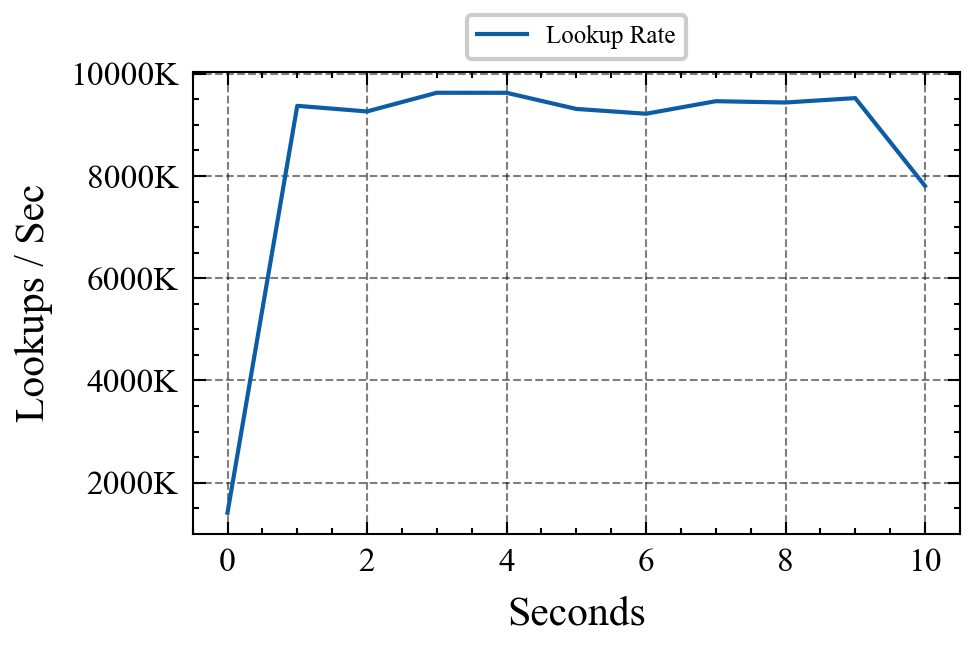

In [3]:
# one connection, many calls
db = EventDB("eventdb_fbt_lookup_external_bp_clock.db")

db.plot_lookup()                           # default everything
# db.plot(show_cols=("tps","total_sec"), containers=(6,))   # custom view
# db.preview(rows=5)                  # peek at raw rows


[eventdb_fbt_lookup_external_vmcache.db] aligned at epoch-second 1747874304.0


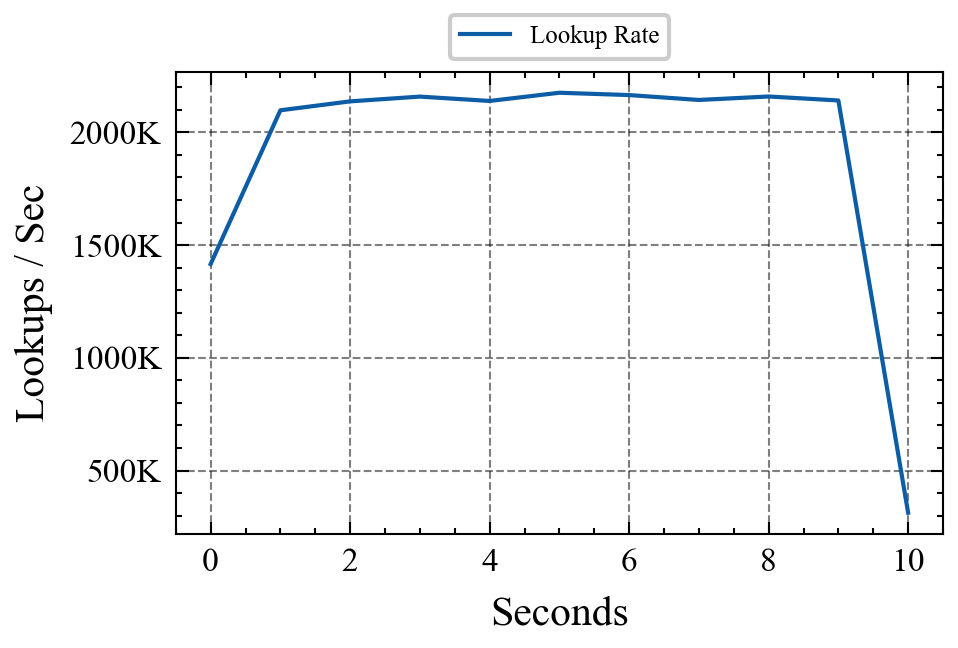

In [4]:
db = EventDB("eventdb_fbt_lookup_external_vmcache.db")
db.plot_lookup()                           # default everything

[events2.db] aligned at epoch-second 1747502866.0


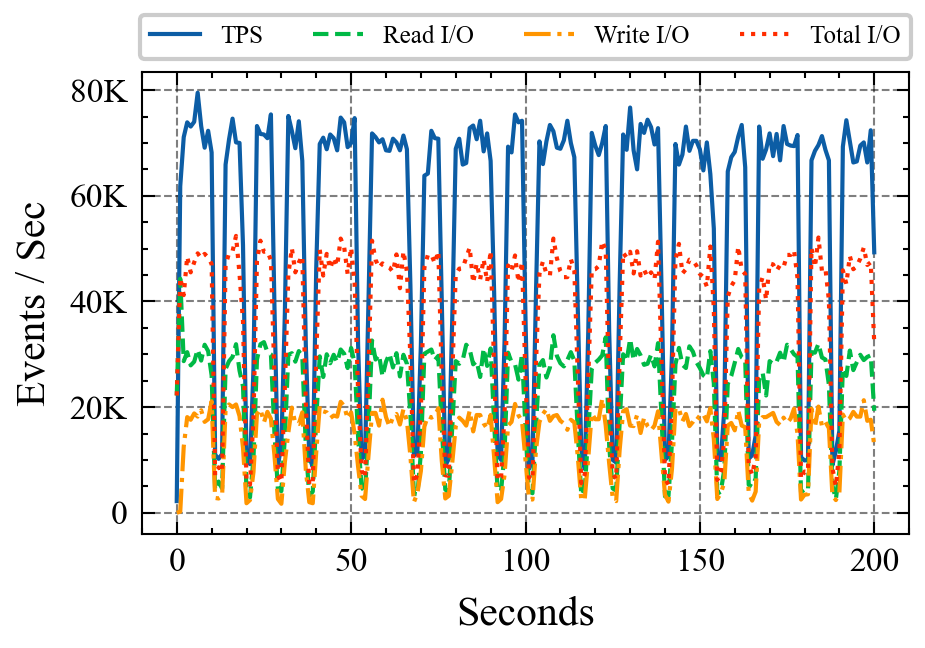

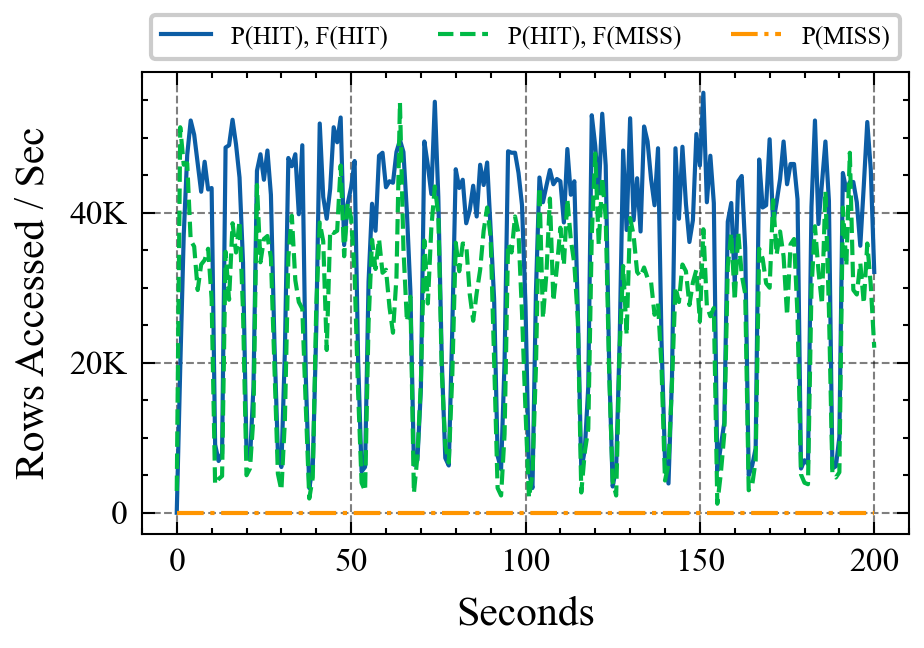

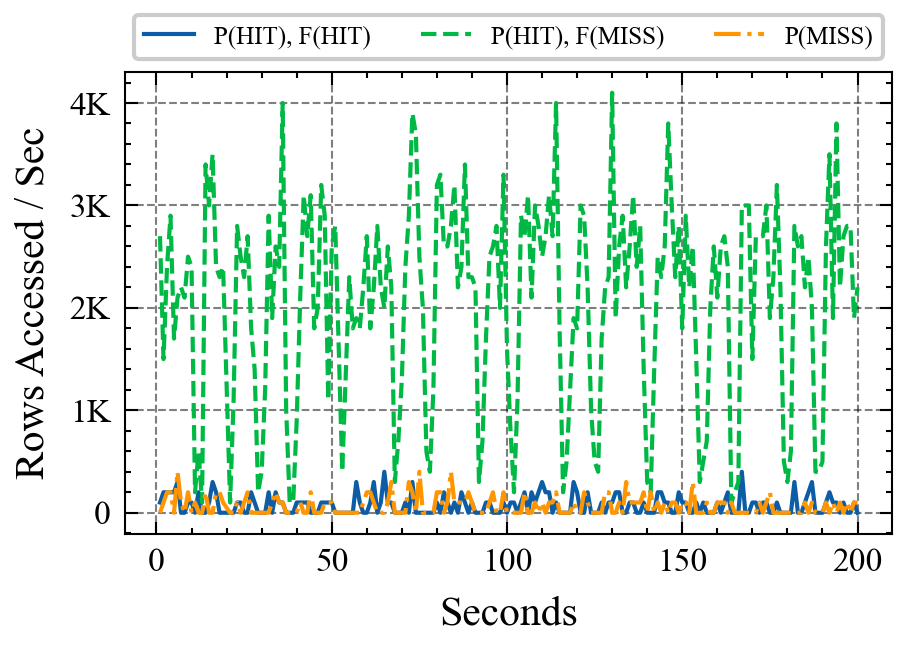

In [ ]:
# open a *second* file without touching the first
other = EventDB("events2.db")
other.plot()                       # default everything
